In [1]:
# imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
dataset = MNIST(root="data/",download=True)

0.3%

100.0%


Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw



102.8%

Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw




2.9%

100.0%


Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw



112.7%

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw



In [3]:
len(dataset)

60000

In [4]:
test_dataset = MNIST(root="data/",train=False)
len(test_dataset)

10000

In [5]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x2203A794F10>, 5)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

Label:  5


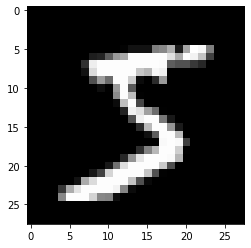

In [8]:
image,label = dataset[0]
plt.imshow(image, cmap='gray')
print("Label: ",label)

Label:  0


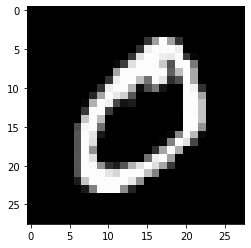

In [9]:
image,label = dataset[1]
plt.imshow(image, cmap='gray')
print("Label: ",label)

# Transform img to Tensors

we need to convert these images to tensors so that pytorch can work with them. For that we have the torch vision library.

In [12]:
from torchvision.transforms import transforms

In [13]:
dataset = MNIST(root="data/", train = True, transform=transforms.ToTensor())

In [15]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The first dimension tells us the colors, the next two give us the height and width. 

In [16]:
print(img_tensor[:,10:15,10:15])

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])


We will get a 5X5 matrix which shows us the color of a particular excerpt of the img. And have values from 0 to 1

Value of 1 represents white<br>
Value of 0 represents black.

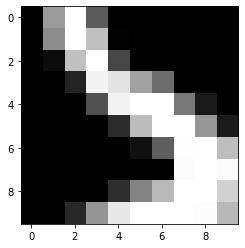

In [20]:
# to show image of selected area
plt.imshow(img_tensor[0,10:20,10:20], cmap="gray")


# Training and Validation Datasets 

While building real-world machine learning models, it is quite common to split the dataset into three parts:

1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
2. **Validation set** - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
3. **Test set** - used to compare different models or approaches and report the model's final accuracy.

In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images. 

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the `random_spilt` method from PyTorch.

In [22]:
# Creating function to split test into test and validation sets using np
import numpy as np
def split_indices(n, val_percent): # n is total number of values in train set. val_percent is percent to be used for validation set
    n_validation = int(n * val_percent) # number of entries in validation set
    random_indices = np.random.permutation(n) # gives a set of values from 0 to n which are randonly selected
    return random_indices[n_validation:], random_indices[:n_validation] 

In [31]:
train_indices, val_indices = split_indices(len(dataset), 0.2)

now we have training set and validation set indices

In [32]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [33]:
batch_size = 100

train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, batch_size, sampler = train_sampler)


val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size, sampler = val_sampler)

# Model

So the model will be quite similar to Linear Regression. Logistic Regression in itself is similar to Linear Regression. 

We will hence be using the the pred to be: <br>
<strong> pred = x @ w.t() + b </strong>

So we can do this via nn.Linear. <br>
Along wit this we will flatten the [1,28,28] image to be a vector of size 784(28*28) and this will be our input. <br>
The output will be a vector of size 10 with each element predicting the probability of number being of its respective index. 


In [37]:
import torch.nn as nn

In [38]:
input_size = 28*28
num_classes = 10
model = nn.Linear(input_size, num_classes)

In [39]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[ 0.0148, -0.0026, -0.0340,  ...,  0.0343,  0.0289,  0.0115],
        [ 0.0228,  0.0347,  0.0156,  ...,  0.0055,  0.0026,  0.0265],
        [ 0.0029,  0.0024,  0.0059,  ..., -0.0095, -0.0331, -0.0212],
        ...,
        [-0.0173,  0.0267,  0.0022,  ...,  0.0095, -0.0345, -0.0031],
        [-0.0022,  0.0154,  0.0211,  ..., -0.0007,  0.0038, -0.0031],
        [-0.0028, -0.0129,  0.0059,  ..., -0.0289, -0.0022, -0.0285]],
       requires_grad=True)

In [40]:
print(model.bias.shape)
print(model.bias)


torch.Size([10])
Parameter containing:
tensor([-4.3022e-03, -5.3514e-05, -2.6088e-02, -2.9646e-02, -2.8009e-02,
         1.7267e-03,  1.3888e-02, -2.2585e-02,  2.5290e-02, -7.5793e-03],
       requires_grad=True)


### Note
Now we will run into an issue. Because our image is of shape [1,28,28] and hence cannot be multiplied by our weights which is a vector of 784 size. 
So we will need to .reshape() the image. 

So we will need to create a custom model, which can facilitate the same. So here we will make another class which will serve as our new model and it will be made by extending the nn.Module class. 
We will then assign create an instance of this class as our new model and use it.

In [54]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes) # we are creating a nn.Linear model here by default. 
        # which can be referenced via the linear parameter of the class.
    
    def forward(self,xb):
        xb = xb.reshape(-1,784) 
        out = self.linear(xb)
        return out
        

In [55]:
model = MnistModel()

This also means that we cannot access our weights and models from the model class directly. We need to access it via the linear in the model

In [56]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [57]:
model.linear.weight, model.linear.bias

(Parameter containing:
 tensor([[-0.0342, -0.0287,  0.0265,  ...,  0.0150, -0.0176,  0.0183],
         [ 0.0035, -0.0207, -0.0131,  ...,  0.0092, -0.0085,  0.0298],
         [-0.0257, -0.0132,  0.0212,  ...,  0.0069, -0.0151,  0.0301],
         ...,
         [-0.0064, -0.0187,  0.0025,  ..., -0.0093, -0.0320, -0.0204],
         [ 0.0271,  0.0242,  0.0047,  ...,  0.0140, -0.0136, -0.0032],
         [-0.0352,  0.0272,  0.0117,  ...,  0.0199,  0.0342, -0.0324]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0180, -0.0167,  0.0276, -0.0227, -0.0009, -0.0196, -0.0128,  0.0111,
          0.0304,  0.0212], requires_grad=True))

In [59]:
list(model.parameters()) # we can do this as we are extending the nn.Module class

[Parameter containing:
 tensor([[-0.0342, -0.0287,  0.0265,  ...,  0.0150, -0.0176,  0.0183],
         [ 0.0035, -0.0207, -0.0131,  ...,  0.0092, -0.0085,  0.0298],
         [-0.0257, -0.0132,  0.0212,  ...,  0.0069, -0.0151,  0.0301],
         ...,
         [-0.0064, -0.0187,  0.0025,  ..., -0.0093, -0.0320, -0.0204],
         [ 0.0271,  0.0242,  0.0047,  ...,  0.0140, -0.0136, -0.0032],
         [-0.0352,  0.0272,  0.0117,  ...,  0.0199,  0.0342, -0.0324]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0180, -0.0167,  0.0276, -0.0227, -0.0009, -0.0196, -0.0128,  0.0111,
          0.0304,  0.0212], requires_grad=True)]

Finally we will pass the images into our model to get the outputs.

In [76]:
for images, labels in train_loader: 
    outputs = model(images)
    break

In [77]:
print(outputs[:2])

tensor([[ 0.1208, -0.2691, -0.5300, -0.1142, -0.0899,  0.3923,  0.1140,  0.1554,
          0.0325, -0.3034],
        [-0.1093, -0.0547, -0.2469, -0.0045,  0.1374,  0.3097,  0.2427,  0.2564,
         -0.1285, -0.1923]], grad_fn=<SliceBackward0>)


## SoftMax Probability

As we can see that the output we get are in negative. This in no way shows probabilities. Not only that but, the sum of all elems of target isnt 1. 

To bring it into probability form we use the SoftMax probability which is easy to implement and use.  

![softmax](https://i.imgur.com/EAh9jLN.png)


In [78]:
import torch.nn.functional as F

In [79]:
probs = F.softmax(outputs, dim = 1)
print(probs[0].data)
print(torch.sum(probs[0]).item())

tensor([0.1148, 0.0777, 0.0599, 0.0908, 0.0930, 0.1506, 0.1140, 0.1189, 0.1051,
        0.0751])
0.9999999403953552


Max of the probabilities will be the output prediction

In [80]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)

tensor([5, 5, 6, 5, 5, 3, 8, 5, 5, 5, 5, 6, 5, 5, 5, 5, 4, 6, 5, 6, 5, 5, 5, 3,
        9, 7, 5, 5, 5, 8, 5, 5, 3, 5, 5, 5, 8, 5, 1, 5, 9, 1, 8, 5, 5, 3, 3, 1,
        5, 5, 6, 5, 5, 5, 5, 8, 5, 7, 5, 5, 5, 8, 8, 1, 0, 6, 4, 5, 5, 3, 5, 3,
        8, 5, 7, 5, 1, 1, 5, 7, 5, 5, 1, 5, 5, 6, 8, 6, 5, 5, 3, 5, 5, 5, 6, 5,
        5, 5, 1, 6])


In [82]:
labels

tensor([5, 8, 0, 7, 3, 2, 6, 1, 1, 4, 9, 7, 4, 3, 3, 3, 6, 6, 1, 8, 4, 5, 2, 4,
        7, 3, 5, 6, 6, 9, 3, 0, 4, 8, 3, 7, 7, 1, 1, 0, 7, 6, 6, 9, 3, 4, 7, 2,
        9, 9, 6, 8, 7, 1, 8, 3, 8, 5, 5, 5, 2, 2, 9, 8, 0, 7, 6, 8, 8, 6, 4, 2,
        4, 5, 3, 9, 2, 2, 6, 1, 9, 6, 4, 6, 6, 6, 7, 7, 8, 8, 8, 3, 6, 5, 7, 4,
        5, 2, 1, 6])

It is normal to see that our predictions dont match our targets. This is because the initial weights and biases taken were random.
Once we apply loss functions and change our model bit by bit we will see our predictions match targets better. 

## Evaluation Metrics and Loss Function

We need to have an accuracy and loss measure to make changes to our model

In [84]:
def accuracy(l1, l2):
    return torch.sum(l1==l2).item()/len(l1)

In [85]:
accuracy(preds, labels)

0.15

## Loss Function - Cross Entropy

Accuracy is an excellent way for us (humans) to evaluate the model. However, we can't use it as a loss function for optimizing our model using gradient descent for the following reasons:

1. It's not a differentiable function. `torch.max` and `==` are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

2. It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements. 

For these reasons, accuracy is often used as an **evaluation metric** for classification, but not as a loss function. A commonly used loss function for classification problems is the **cross-entropy**, which has the following formula:

![cross-entropy](https://i.imgur.com/VDRDl1D.png)

While it looks complicated, it's actually quite simple:

* For each output row, pick the predicted probability for the correct label. E.g., if the predicted probabilities for an image are `[0.1, 0.3, 0.2, ...]` and the correct label is `1`, we pick the corresponding element `0.3` and ignore the rest.

* Then, take the [logarithm](https://en.wikipedia.org/wiki/Logarithm) of the picked probability. If the probability is high, i.e., close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

![](https://www.intmath.com/blog/wp-content/images/2019/05/log10.png)

* Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.

Unlike accuracy, cross-entropy is a continuous and differentiable function. It also provides useful feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). These two factors make cross-entropy a better choice for the loss function.

As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross-entropy as part of the `torch.nn.functional` package. Moreover, it also performs softmax internally, so we can directly pass in the model's outputs without converting them into probabilities.

In [87]:
outputs[:2]

tensor([[ 0.1208, -0.2691, -0.5300, -0.1142, -0.0899,  0.3923,  0.1140,  0.1554,
          0.0325, -0.3034],
        [-0.1093, -0.0547, -0.2469, -0.0045,  0.1374,  0.3097,  0.2427,  0.2564,
         -0.1285, -0.1923]], grad_fn=<SliceBackward0>)

In [88]:
loss_fn = F.cross_entropy 

In [89]:
loss = loss_fn(outputs, labels)

In [90]:
loss

tensor(2.3025, grad_fn=<NllLossBackward0>)

## Optimizer 

In [91]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

## Training the model

Making a loss batch whose function will be to get loss of a batch, and optimize model if told to and give accuracy metrics if told to. 

In [92]:
def loss_batch(model, loss_fn, xb, yb, opt = None, metrics = None):
    preds = model(xb)
    loss = loss_fn(preds, yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    metric_result = None
    if metrics is not None:
        metric_result = metrics(preds, yb)
        
    return loss.item(), len(xb), metric_result


to evaluate 

In [97]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        # Pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metrics=metric) for xb, yb in valid_dl]
        # Separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        # Total size of the dataset
        total = np.sum(nums)
        # Avg. loss across batches
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None:
            # Avg. of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric


In [98]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds==labels).item()/len(preds)


In [99]:
val_loss, total, val_acc = evaluate(model, loss_fn, val_loader, metric = accuracy)
print ('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

Loss: 2.3231, Accuracy: 0.0922


## Fit 

Once we have checked our validation dataset, we can actually move on to our actual fit function.

In [100]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl, metric = None):
    for epoch in range(epochs):
        # training
        for xb, yb in train_dl:
            loss,_,_ = loss_batch(model,loss_fn,xb,yb,opt=opt)
        
        # Evaluation
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        
        # Seeing Progress
        if metric is None:
            print ('Epoch [{}/{}], Loss: {:.4f}'.format (epoch+1, epochs, val_loss))
        else:
            print ('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'.format (epoch+1, epochs, val_loss, metric.__name__, val_metric))

In [101]:
# make model again
model = MnistModel()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [102]:
fit(5,model, loss_fn, optimizer, train_loader, val_loader, accuracy)

Epoch [1/5], Loss: 1.8864, accuracy: 0.6358
Epoch [2/5], Loss: 1.5894, accuracy: 0.7378
Epoch [3/5], Loss: 1.3801, accuracy: 0.7708
Epoch [4/5], Loss: 1.2293, accuracy: 0.7912
Epoch [5/5], Loss: 1.1175, accuracy: 0.8050


In just 5 epochs, our accuracy is now 80%!! 

The accuracy jumps quite high in very less epochs. 



In [103]:
fit(5,model, loss_fn, optimizer, train_loader, val_loader, accuracy)

Epoch [1/5], Loss: 1.0318, accuracy: 0.8148
Epoch [2/5], Loss: 0.9642, accuracy: 0.8217
Epoch [3/5], Loss: 0.9096, accuracy: 0.8275
Epoch [4/5], Loss: 0.8645, accuracy: 0.8315
Epoch [5/5], Loss: 0.8267, accuracy: 0.8338


![Relation of accuracy with epochs](./data/download.png) <br>
Relation of accuracy with epochs

It's quite clear from the above picture that the model probably won't cross the accuracy threshold of 90% even after training for a very long time. One possible reason for this is that the learning rate might be too high. The model's parameters may be "bouncing" around the optimal set of parameters for the lowest loss. You can try reducing the learning rate and training for a few more epochs to see if it helps.

The more likely reason that **the model just isn't powerful enough**. If you remember our initial hypothesis, we have assumed that the output (in this case the class probabilities) is a **linear function** of the input (pixel intensities), obtained by perfoming a matrix multiplication with the weights matrix and adding the bias. This is a fairly weak assumption, as there may not actually exist a linear relationship between the pixel intensities in an image and the digit it represents. While it works reasonably well for a simple dataset like MNIST (getting us to 85% accuracy), we need more sophisticated models that can capture non-linear relationships between image pixels and labels for complex tasks like recognizing everyday objects, animals etc. 

## Testing

In [105]:
test_dataset = MNIST(root="data/", train=False, transform = transforms.ToTensor())

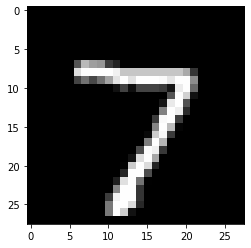

In [107]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap="gray")

In [110]:
def predict_img(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 Predicted: 7


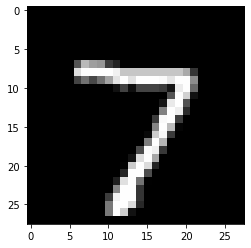

In [111]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap="gray")
print("Label:",label,"Predicted:",predict_img(img, model))

Label: 0 Predicted: 0


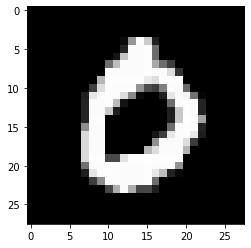

In [116]:
img, label = test_dataset[3]
plt.imshow(img[0], cmap="gray")
print("Label:",label,"Predicted:",predict_img(img, model))

Label: 3 Predicted: 3


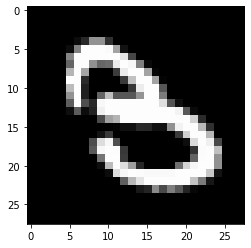

In [117]:
img, label = test_dataset[18]
plt.imshow(img[0], cmap="gray")
print("Label:",label,"Predicted:",predict_img(img, model))

Label: 6 Predicted: 0


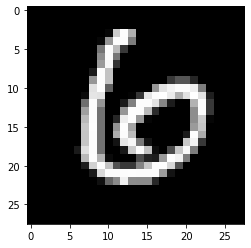

In [128]:
img, label = test_dataset[11]
plt.imshow(img[0], cmap="gray")
print("Label:",label,"Predicted:",predict_img(img, model))

# Here we can see that our prediction is wrong and this is the drawback of logistic regression

In [129]:
test_loader = DataLoader(test_dataset, batch_size =200)
test_loss, total, test_acc = evaluate(model, loss_fn, test_loader, accuracy)
print("Loss:", test_loss, "Accuracy:", test_acc)

Loss: 0.7962945294380188 Accuracy: 0.8443


## Saving and Loading Model

In [130]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [131]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0162, -0.0094,  0.0020,  ..., -0.0242, -0.0127, -0.0310],
                      [ 0.0123, -0.0022,  0.0237,  ...,  0.0270,  0.0167, -0.0134],
                      [ 0.0106,  0.0027,  0.0285,  ..., -0.0315, -0.0353,  0.0055],
                      ...,
                      [-0.0032,  0.0082,  0.0003,  ..., -0.0243, -0.0300,  0.0134],
                      [ 0.0189,  0.0354,  0.0159,  ...,  0.0086,  0.0264,  0.0284],
                      [ 0.0346,  0.0340, -0.0075,  ...,  0.0279,  0.0251,  0.0028]])),
             ('linear.bias',
              tensor([-0.0593,  0.0641,  0.0029, -0.0339,  0.0527, -0.0089,  0.0242,  0.0597,
                      -0.0633,  0.0317]))])

In [132]:
# to load model create an instance of mnist and then load model
model2 = MnistModel()
model2.load_state_dict(torch.load('mnist-logistic.pth'))


<All keys matched successfully>

In [133]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0162, -0.0094,  0.0020,  ..., -0.0242, -0.0127, -0.0310],
                      [ 0.0123, -0.0022,  0.0237,  ...,  0.0270,  0.0167, -0.0134],
                      [ 0.0106,  0.0027,  0.0285,  ..., -0.0315, -0.0353,  0.0055],
                      ...,
                      [-0.0032,  0.0082,  0.0003,  ..., -0.0243, -0.0300,  0.0134],
                      [ 0.0189,  0.0354,  0.0159,  ...,  0.0086,  0.0264,  0.0284],
                      [ 0.0346,  0.0340, -0.0075,  ...,  0.0279,  0.0251,  0.0028]])),
             ('linear.bias',
              tensor([-0.0593,  0.0641,  0.0029, -0.0339,  0.0527, -0.0089,  0.0242,  0.0597,
                      -0.0633,  0.0317]))])